In [1]:
import pandas as pd
import numpy as np
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix
import nltk
import nltk.corpus 
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
from gensim.models.word2vec import Word2Vec

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kiranrawat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_news = pd.read_csv('../data/processed/train.csv')
val_news = pd.read_csv('../data/processed/val.csv')
test_news = pd.read_csv('../data/processed/test.csv')

In [3]:
print("====Label Distribution in Training Data ====")
print(train_news['label'].value_counts())
print("====Label Distribution in Validation Data ====")
print(val_news['label'].value_counts())
print("====Label Distribution in Test Data====")
print(test_news['label'].value_counts())

====Label Distribution in Training Data ====
True     5752
False    4488
Name: label, dtype: int64
====Label Distribution in Validation Data ====
True     668
False    616
Name: label, dtype: int64
====Label Distribution in Test Data====
True     714
False    553
Name: label, dtype: int64


By seeing the label's distribution, it seems like a balanced class. As number of 'True' and 'False' lables are kind of equally distributed in the dataset.

In [4]:
train_news.groupby('label').describe()

statement                                                               
          count unique                                                top freq
label                                                                         
False      4488   4481  On changing the rules for filibusters on presi...    3
True       5752   5746  Six justices on the U.S. Supreme Court have be...    2

from above information, we know that:

1. About 44% of the statements are classified as a True.
2. There are some duplicate messages, since the number of unique values lower than the count values of the text.

In the next part, lext check the length of each text messages to see whether it is correlated with the text classified as a True or False.

In [5]:
train_news['length'] = train_news['statement'].apply(len)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1243f65b0>,
      dtype=object)

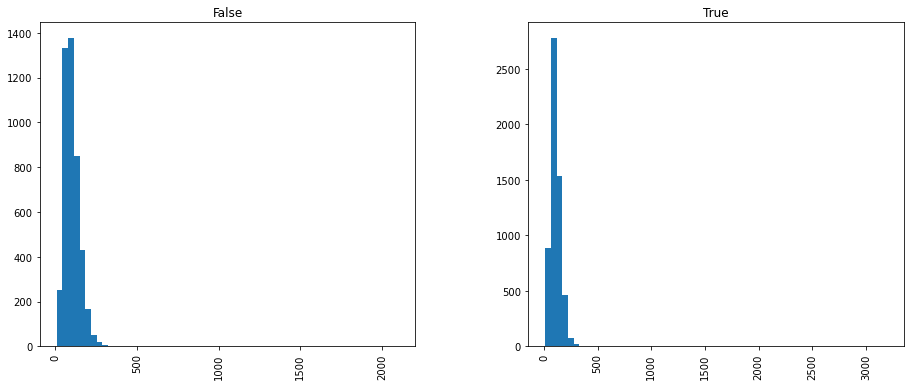

In [6]:
train_news.hist(column='length',by='label',bins=60, figsize=(15,6))

from above figure, we can see almost both True and False statements have length under 500.

In [7]:
def process_text(text):
    '''
    What will be covered:
    1. Remove punctuation
    2. Remove stopwords
    3. Return list of clean text words
    '''
    
    #1
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    #2
    clean_words = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    
    #3
    return clean_words

In [8]:
train_news['statement'].apply(process_text).head()

0    [Says, Annies, List, political, group, support...
1    [decline, coal, start, started, natural, gas, ...
2    [Hillary, Clinton, agrees, John, McCain, votin...
3    [Health, care, reform, legislation, likely, ma...
4           [economic, turnaround, started, end, term]
Name: statement, dtype: object

## Feature Weighting

Not all words are equally important to a particular document / category. For example, while words like ‘murder’, ‘knife’ and ‘abduction’ are important to a crime related document, words like ‘news’ and ‘reporter’ may not be quite as important. 

### Binary Weighting
The most basic form of feature weighting, is binary weighting. Where if a word is present in a document, the weight is ‘1’ and if the word is absent the weight is ‘0’. 

### CountVectorizer

It Convert a collection of text documents to a matrix of token counts.


### Tfidf Weighting 

TF-IDF weighting where words that are unique to a particular document would have higher weights compared to words that are used commonly across documents. 

1. TF (Term Frequency): The number of times a word appears in a document divded by the total number of words in the document. Every document has its own term frequency.

2. IDF (Inverse Data Frequency): The log of the number of documents divided by the number of documents that contain the word w. Inverse data frequency determines the weight of rare words across all documents in the corpus.

3. Lastly, the TF-IDF is simply the TF multiplied by IDF.

In [9]:
count_vect = CountVectorizer(analyzer=process_text)
X_train_counts = count_vect.fit_transform(train_news.statement)
X_train_counts.shape

(10240, 14694)

Here by doing ‘count_vect.fit_transform(train_news.statement)’, we are learning the vocabulary dictionary and it returns a Document-Term matrix. [n_samples, n_features]

In [10]:
print(count_vect)
print(X_train_counts)

CountVectorizer(analyzer=<function process_text at 0x10c8769d0>, binary=False,
                decode_error='strict', dtype=<class 'numpy.int64'>,
                encoding='utf-8', input='content', lowercase=True, max_df=1.0,
                max_features=None, min_df=1, ngram_range=(1, 1),
                preprocessor=None, stop_words=None, strip_accents=None,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None,
                vocabulary=None)
  (0, 4480)	1
  (0, 1168)	1
  (0, 3292)	1
  (0, 11437)	1
  (0, 9014)	1
  (0, 13467)	1
  (0, 13747)	1
  (0, 5396)	1
  (0, 7472)	1
  (1, 7386)	1
  (1, 6780)	1
  (1, 13218)	1
  (1, 13219)	2
  (1, 10660)	1
  (1, 8841)	1
  (1, 13828)	1
  (1, 6113)	1
  (1, 4098)	1
  (1, 2529)	1
  (1, 5172)	1
  (1, 1523)	1
  (1, 5513)	1
  (2, 2529)	1
  (2, 2759)	1
  (2, 1745)	1
  :	:
  (10237, 2498)	1
  (10237, 11151)	1
  (10237, 10932)	1
  (10238, 5074)	1
  (10238, 5665)	1
  (10238, 1907)	1
  (10238, 13934)	1
  (10238, 8024)	1
  (10238, 1908)	1
  (10238,

In [11]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(10240, 14694)

In [12]:
print(X_train_tfidf)

  (0, 13747)	0.4111721462668922
  (0, 13467)	0.268763909950058
  (0, 11437)	0.288299097736884
  (0, 9014)	0.29572900100023347
  (0, 7472)	0.3487778612305985
  (0, 5396)	0.2913344923941701
  (0, 4480)	0.11315616700304243
  (0, 3292)	0.42942130476966167
  (0, 1168)	0.42942130476966167
  (1, 13828)	0.1992848257109974
  (1, 13219)	0.4969030230072441
  (1, 13218)	0.2798176297170201
  (1, 10660)	0.2739440793861925
  (1, 8841)	0.22394629275523875
  (1, 7386)	0.3062283783186632
  (1, 6780)	0.2758031142293708
  (1, 6113)	0.295266927264955
  (1, 5513)	0.20276327129406949
  (1, 5172)	0.24939236562772774
  (1, 4098)	0.16242753464879256
  (1, 2529)	0.21935004602848507
  (1, 1523)	0.2739440793861925
  (2, 14363)	0.2756773185579947
  (2, 8899)	0.26938879684469363
  (2, 7809)	0.39530812320324743
  :	:
  (10237, 4480)	0.08541385115156024
  (10237, 2498)	0.3005921835315536
  (10237, 1869)	0.18420294004003412
  (10238, 13934)	0.39490677491613024
  (10238, 10075)	0.43475306416516835
  (10238, 8024)	0.4237

In [14]:
count_vect.get_feature_names()

['0',
 '005',
 '01',
 '02',
 '025',
 '03',
 '04',
 '047',
 '05',
 '06',
 '07',
 '0809',
 '09',
 '1',
 '10',
 '100',
 '1000',
 '10000',
 '100000',
 '100000000',
 '100000The',
 '1000plus',
 '100billion',
 '100million',
 '100plus',
 '100round',
 '100th',
 '100watt',
 '100yearold',
 '1010',
 '1017',
 '102000',
 '103',
 '103000',
 '1033',
 '1034',
 '104',
 '104000',
 '10420',
 '1045',
 '105',
 '106',
 '106258',
 '107',
 '1070',
 '10728',
 '108',
 '109',
 '10932json',
 '10billion',
 '10in',
 '10million',
 '10percent',
 '10th',
 '10year',
 '10yearold',
 '11',
 '110',
 '1100',
 '11000',
 '11000squarefoot',
 '11023json',
 '110billion',
 '110million',
 '110th',
 '111',
 '11100',
 '111th',
 '112',
 '112th',
 '1130',
 '113000',
 '114',
 '115',
 '115000',
 '116838763',
 '119000',
 '11900json',
 '11collecting',
 '11plus',
 '11th',
 '11yearold',
 '12',
 '120',
 '1200',
 '12000',
 '120000',
 '120member',
 '12189json',
 '123',
 '124',
 '124000',
 '125',
 '12500',
 '125000',
 '12670json',
 '1270',
 '128